In [1]:
import numpy as np
import torch
import os
import pandas as pd
import torch_geometric
import pickle
import tqdm
import random

/home/icb/vnicolas.goedert/miniconda3/envs/RFAM/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rfam_dir = "../rfam/data/raw/processed/release-14.8"
rfam = "RF04088"

In [3]:
from RNARepLearn.datasets import SingleRfamDataset
rfam_dataset = SingleRfamDataset(rfam_dir,rfam,15)
rfam_dataset

Processing...
Done!


SingleRfamDataset(4988)

In [4]:
train_size = int(0.8 * len(rfam_dataset))
test_size = len(rfam_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(rfam_dataset, [train_size, test_size])

In [5]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
##Model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear

class Encoder(torch.nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = GCNConv(input_channels, output_channels)

        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        #build representation, encode
        # input -> V_N,D
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        return x
    
class AttentionDecoder(torch.nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.key_projection = Linear(input_channels, input_channels)
        self.query_projection = Linear(input_channels, input_channels)
        self.nuc_projection = Linear(input_channels, output_channels)
        
    def forward(self, x):
        keys = self.key_projection(x)
        queries = self.query_projection(x)
        
        nucleotides = self.nuc_projection(x)
        
        dotprod = torch.matmul(queries,keys.T)
        
        return F.softmax(nucleotides, dim=1), F.softmax(dotprod, dim=1)
    

In [18]:
layers = []
layers.append(Encoder(4,64))
layers.append(AttentionDecoder(64,4))
model = torch.nn.Sequential(*layers)

In [19]:
##Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

n_epochs = 10

In [20]:
from RNARepLearn.utils import mask_batch
##Training
train_hist = {}
train_hist["loss"]=[]
train_hist["nucleotide_loss"]=[]
train_hist["edge_loss"]=[]
model.train()
cel_loss = torch.nn.CrossEntropyLoss()
kl_loss = torch.nn.KLDivLoss(reduction='batchmean')

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        
        true_x = torch.clone(batch.x)
        true_edges = torch.clone(batch.edge_weight)

        nuc_mask, edge_mask = mask_batch(batch,15)
        batch.to(device)
        optimizer.zero_grad()
        
        nucs, bpp = model(batch)

        node_loss = cel_loss(nucs.cpu()[nuc_mask],true_x[nuc_mask])
        edge_loss = kl_loss(bpp.cpu()[batch.edge_index[0][edge_mask],batch.edge_index[1][edge_mask]].log() , true_edges[edge_mask])
        
        loss = node_loss + edge_loss

        loss.backward()
        optimizer.step()
        train_hist["loss"].append(loss.item())
        train_hist["nucleotide_loss"].append(node_loss.item())
        train_hist["edge_loss"].append(edge_loss.item())
        
        
        
        
        print('\r[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e Nucleotide-Loss: % 2.2e Edge-Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item(),node_loss.item(),edge_loss.item()))
    

[Epoch    1/  10] [Batch    1/ 125] Loss:  1.47e+00 Nucleotide-Loss:  1.39e+00 Edge-Loss:  8.65e-02
[Epoch    1/  10] [Batch    2/ 125] Loss:  1.46e+00 Nucleotide-Loss:  1.37e+00 Edge-Loss:  8.76e-02
[Epoch    1/  10] [Batch    3/ 125] Loss:  1.44e+00 Nucleotide-Loss:  1.35e+00 Edge-Loss:  8.71e-02
[Epoch    1/  10] [Batch    4/ 125] Loss:  1.42e+00 Nucleotide-Loss:  1.33e+00 Edge-Loss:  8.50e-02
[Epoch    1/  10] [Batch    5/ 125] Loss:  1.40e+00 Nucleotide-Loss:  1.32e+00 Edge-Loss:  8.71e-02
[Epoch    1/  10] [Batch    6/ 125] Loss:  1.38e+00 Nucleotide-Loss:  1.29e+00 Edge-Loss:  8.62e-02
[Epoch    1/  10] [Batch    7/ 125] Loss:  1.36e+00 Nucleotide-Loss:  1.27e+00 Edge-Loss:  8.61e-02
[Epoch    1/  10] [Batch    8/ 125] Loss:  1.33e+00 Nucleotide-Loss:  1.24e+00 Edge-Loss:  8.58e-02
[Epoch    1/  10] [Batch    9/ 125] Loss:  1.33e+00 Nucleotide-Loss:  1.24e+00 Edge-Loss:  8.92e-02
[Epoch    1/  10] [Batch   10/ 125] Loss:  1.29e+00 Nucleotide-Loss:  1.21e+00 Edge-Loss:  8.55e-02


KeyboardInterrupt: 

In [17]:
len(bpp.cpu()[batch.edge_index[0][edge_mask],batch.edge_index[1][edge_mask]])

142215

In [15]:
true_edges[edge_mask]

tensor([4.5824e-01, 1.0181e-10, 1.3622e-16,  ..., 2.4203e-20, 2.9680e-22,
        1.5857e-19], dtype=torch.float64)

<AxesSubplot: >

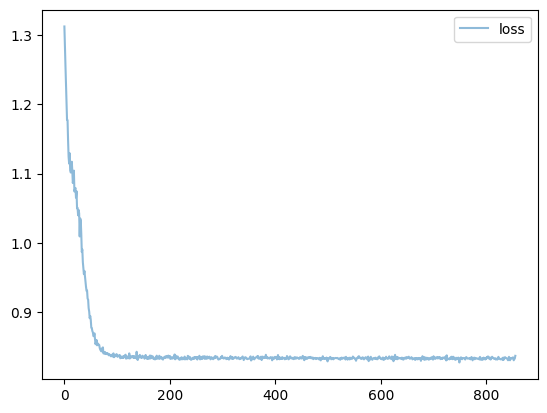

In [11]:
import pandas as pd
p_df = pd.DataFrame({"loss":train_hist['loss']})
p_df.plot(alpha=0.5)

<AxesSubplot: >

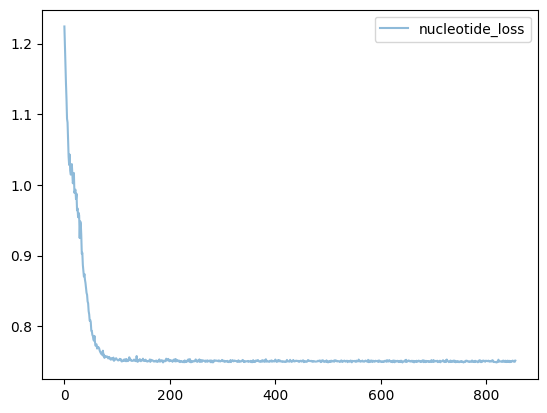

In [12]:
p_df = pd.DataFrame({"nucleotide_loss":train_hist['nucleotide_loss']})
p_df.plot(alpha=0.5)

<AxesSubplot: >

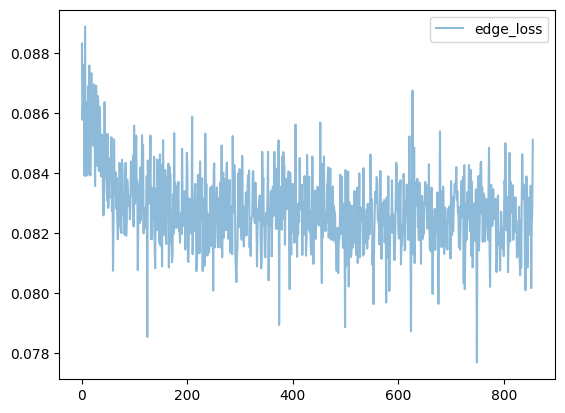

In [13]:
p_df = pd.DataFrame({"edge_loss":train_hist['edge_loss']})
p_df.plot(alpha=0.5)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)